<a href="https://colab.research.google.com/github/jwilliams2023/Machine-Learning-Assignments/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn
- nltk
- gensim
- datasets
- transformers
- torch
- evaluate


In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn nltk gensim datasets transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Question 1 - Word Embeddings and N-gram

In [2]:
import gensim.downloader as api
from gensim.models import FastText
from gensim.test.utils import common_texts

print(common_texts[0])
print(len(common_texts[0]))

['human', 'interface', 'computer']
3


### 1. (a)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd


In [4]:
words = ["Dog", "Bark", "Tree", "Bank", "River", "Money"]

In [5]:
def compute_similarity_matrix(model, words):
  vectors = []
  labels = []
  for word in words:
    key = word.lower()
    if key in model:
      vectors.append(model[key])
      labels.append(word)
    else:
      print(word, "not found in vocab")

  similarity_matrix = cosine_similarity(vectors)
  df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
  return df

In [6]:
if 'model' not in globals():
    model = api.load('glove-twitter-50')

In [7]:
similarity_matrix = compute_similarity_matrix(model, words)
display(similarity_matrix)

,Dog,Bark,Tree,Bank,River,Money
Dog,1.000000,0.593780,0.713751,0.348236,0.401201,0.575133
Bark,0.593780,1.000000,0.545873,0.040109,0.266635,0.290985
Tree,0.713751,0.545873,1.000000,0.349456,0.487116,0.510081
Bank,0.348236,0.040109,0.349456,1.000000,0.319922,0.674656
River,0.401201,0.266635,0.487116,0.319922,1.000000,0.337800
Money,0.575133,0.290985,0.510081,0.674656,0.337800,1.000000


### 1. (b)

In [8]:
fasttext_model = FastText(sentences=common_texts, vector_size=50, window=5, min_count=1, epochs=10)
fasttext_similarity_matrix = compute_similarity_matrix(fasttext_model.wv,words)
display(fasttext_similarity_matrix)

,Dog,Bark,Tree,Bank,River,Money
Dog,1.000000,0.107832,-0.169992,0.031316,-0.013496,-0.111240
Bark,0.107832,1.000000,0.207565,0.169627,0.086654,-0.046768
Tree,-0.169992,0.207565,1.000000,0.035650,0.065254,-0.263089
Bank,0.031316,0.169627,0.035650,1.000000,0.203295,-0.016420
River,-0.013496,0.086654,0.065254,0.203295,1.000000,-0.122650
Money,-0.111240,-0.046768,-0.263089,-0.016420,-0.122650,1.000000


### 1. (c)

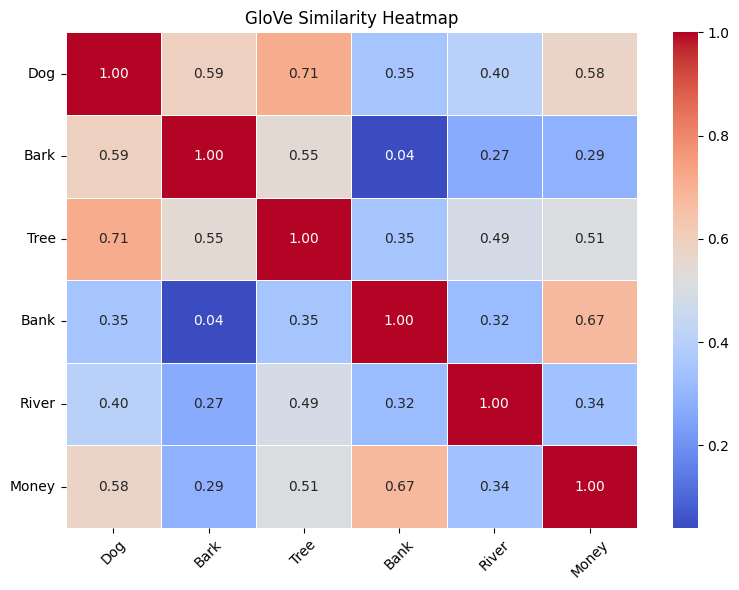

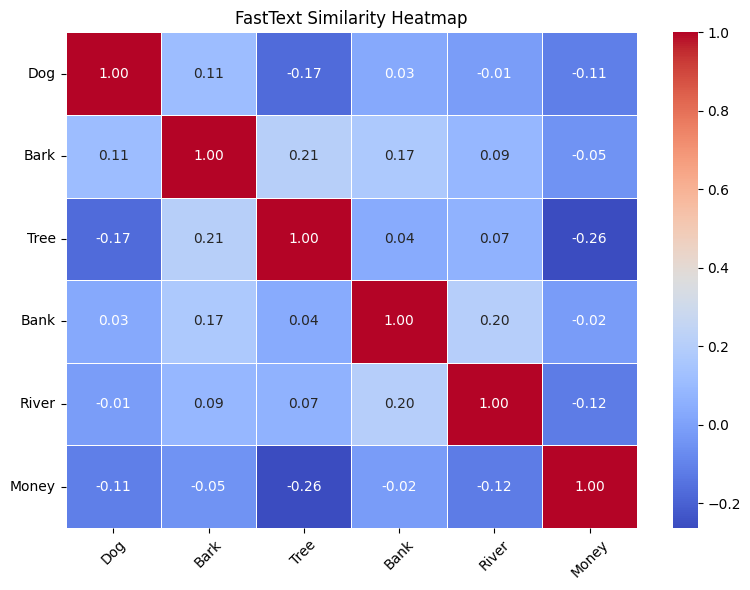

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot a heatmap from a similarity matrix
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot GloVe similarity heatmap
plot_heatmap(similarity_matrix, "GloVe Similarity Heatmap")

# Plot FastText similarity heatmap
plot_heatmap(fasttext_similarity_matrix, "FastText Similarity Heatmap")


#### Which embedding captures better semantics?

Based on the similarity matrices and visualizations, GloVe clearly captures better semantic relationships among the words compared to FastText in this case.

The GloVe model is pretrained on a large-scale Twitter corpus and contains well-established semantic patterns. For example:
- "Dog" and "Bark" have a similarity of 0.59, reflecting their real-world connection.
- "Bank" and "Money" score 0.67, indicating strong financial association.
- "Bank" and "River" also show moderate similarity at 0.32, acknowledging the alternate geographic meaning of "bank."

In contrast, the FastText model, although more flexible in handling out-of-vocabulary words and morphology through subword units, was trained here on a small built-in dataset (common_texts) that lacks real-world context. As a result:
- "Dog" and "Bark" only score 0.11
- "Bank" and "Money" show near-zero similarity (-0.02)
- Many relationships even have negative similarities, indicating noise rather than semantic closeness.

While FastText has the potential to outperform GloVe on domain-specific or rare words if trained on a richer corpus, in this case, GloVe significantly outperforms FastText in capturing meaningful semantic similarities.


### 2. N-grams and Classification (a)

In [10]:
import pandas as pd
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

nltk.download('twitter_samples')
nltk.download('stopwords')

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

all_tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

X_train, X_test, y_train, y_test = train_test_split(all_tweets, labels, test_size=0.3, random_state=77)


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/joe/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/joe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. (b)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = {
    n: CountVectorizer(ngram_range=(n, n), stop_words='english')
    for n in range(1, 5)
}


### 2. (c)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

res = []

for n, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model = LogisticRegression(max_iter=200)
    model.fit(X_train_vec, y_train)

    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)

    res.append((n, acc))
    print(n, "-gram accuracy score", acc)

1 -gram accuracy score 0.7436666666666667
2 -gram accuracy score 0.6163333333333333
3 -gram accuracy score 0.55
4 -gram accuracy score 0.5386666666666666


### 2.

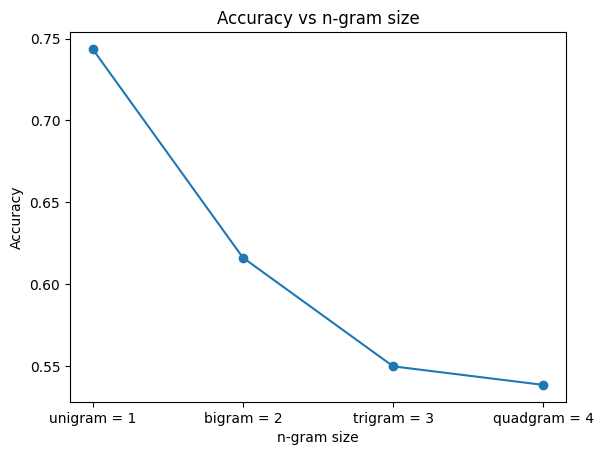

In [13]:
unzipped = list(zip(*res))

ngram_sizes, accuracy_scores = unzipped[0], unzipped[1]

plt.plot(ngram_sizes, accuracy_scores, marker="o")
plt.title("Accuracy vs n-gram size")
plt.xlabel("n-gram size")
plt.ylabel("Accuracy")
# plt.grid(True)
# plt.xticks(ngram_sizes)
plt.xticks(ngram_sizes, labels=["unigram = 1", "bigram = 2", "trigram = 3", "quadgram = 4"])
plt.show()

#### (d) How does the value of n in n-gram affect the model’s performance?

As the value of n increases, the model’s performance decreases. Unigrams (n = 1) gave the highest accuracy, while bigrams, trigrams, and quadgrams showed a steady drop in accuracy.

This is likely because larger n-grams lead to more sparse features. While bigrams and higher can capture more context, they also result in many rare combinations that the model sees too few times to learn from. This can cause overfitting and reduced generalization.

In this case, unigrams performed best due to their simplicity and broad coverage across the dataset.


## Question 2 RNN and Machine Translation

### 1.

In [14]:
# GPU-ready PyTorch with CUDA 11.8
%pip install torch --index-url https://download.pytorch.org/whl/cu118

# Hugging Face datasets + BLEU evaluation
%pip install datasets evaluate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.5.1
CUDA available: False
GPU device name: None


In [16]:
from datasets import load_dataset

# Load BillSum and split
billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.2)


In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

MAX_INPUT_1024 = 1024
MAX_INPUT_2048 = 2048
MAX_TARGET_128 = 128
MAX_TARGET_256 = 256

configurations = [
    {"name": "1024_128", "input_len": MAX_INPUT_1024, "target_len": MAX_TARGET_128},
    {"name": "1024_256", "input_len": MAX_INPUT_1024, "target_len": MAX_TARGET_256},
    {"name": "2048_128", "input_len": MAX_INPUT_2048, "target_len": MAX_TARGET_128},
    {"name": "2048_256", "input_len": MAX_INPUT_2048, "target_len": MAX_TARGET_256},
]

tokenized_versions = {}

for config in configurations:
    def preprocess(example):
        inputs = tokenizer(example["text"], max_length=config["input_len"], truncation=True, padding="max_length")
        targets = tokenizer(example["summary"], max_length=config["target_len"], truncation=True, padding="max_length")
        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels": targets["input_ids"]
        }

    print(f"Tokenizing config: {config['name']}")
    tokenized = billsum.map(preprocess, batched=True)
    tokenized_versions[config["name"]] = tokenized


Tokenizing config: 1024_128


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Tokenizing config: 1024_256


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Tokenizing config: 2048_128


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Tokenizing config: 2048_256


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [19]:
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, input_len, target_len, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt):
        embedded_src = self.dropout(self.embed(src))
        _, (hidden, cell) = self.encoder_lstm(embedded_src)

        embedded_tgt = self.dropout(self.embed(tgt))
        decoder_outputs, _ = self.decoder_lstm(embedded_tgt, (hidden, cell))
        return self.fc_out(decoder_outputs)


In [ ]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            decoder_input = labels[:, :-1]
            decoder_target = labels[:, 1:]

            outputs = model(input_ids, decoder_input)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            decoder_target = decoder_target.reshape(-1)

            loss = criterion(outputs, decoder_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")


In [ ]:
import evaluate

def evaluate_bleu(model, test_loader, tokenizer, device):
    model.eval()
    bleu = evaluate.load("bleu")
    predictions, references = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            decoder_input = labels[:, :-1]

            output_logits = model(input_ids, decoder_input)
            pred_ids = torch.argmax(output_logits, dim=-1)

            decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend([[ref] for ref in decoded_labels])

    score = bleu.compute(predictions=predictions, references=references)
    return score["bleu"]


In [30]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for config in configurations:
    name = config["name"]
    model_path = f"model_{name}.pt"

    data = tokenized_versions[name]
    train_dataset = Seq2SeqDataset(data["train"])
    test_dataset = Seq2SeqDataset(data["test"])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    model = Seq2SeqLSTM(
        vocab_size=tokenizer.vocab_size,
        embed_dim=128,
        hidden_dim=256,
        input_len=config["input_len"],
        target_len=config["target_len"],
        dropout=0.3
    ).to(device)

    if os.path.exists(model_path):
        print(f"Model for {name} already exists. Loading from {model_path}...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        print(f"\nTraining model for config: {name}")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

        train_model(model, train_loader, optimizer, criterion, device, epochs=3)

        torch.save(model.state_dict(), model_path)
        print(f"Saved model to {model_path}")

    bleu_score = evaluate_bleu(model, test_loader, tokenizer, device)
    results.append((name, bleu_score))
    print(f"BLEU score for {name}: {bleu_score:.4f}")


Model for 1024_128 already exists. Loading from model_1024_128.pt...


/var/folders/xx/dcdf2ph51j95qzcp464_68v00000gn/T/ipykernel_70705/173871121.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

BLEU score for 1024_128: 0.0234
Model for 1024_256 already exists. Loading from model_1024_256.pt...
BLEU score for 1024_256: 0.0287


KeyboardInterrupt: 

In [ ]:
print("\nFinal BLEU Scores:")
for name, score in results:
    print(f"{name}: BLEU = {score:.4f}")
#
# %%
best_seq_config = max(results, key=lambda x: x[1])
print("\nBest Sequence Length Configuration:")
print(f"Config: {best_seq_config[0]}")
print(f"BLEU Score: {best_seq_config[1]:.4f}")


Final BLEU Scores:
1024_128: BLEU = 0.0234
1024_256: BLEU = 0.0287
2048_128: BLEU = 0.0221
2048_256: BLEU = 0.0295


In [ ]:
hyperparam_configs = [
    {"name": "emb128_hid256_drp0.3_lr0.001", "embed_dim": 128, "hidden_dim": 256, "dropout": 0.3, "lr": 0.001},
    {"name": "emb256_hid512_drp0.2_lr0.0005", "embed_dim": 256, "hidden_dim": 512, "dropout": 0.2, "lr": 0.0005},
    {"name": "emb512_hid512_drp0.1_lr0.001", "embed_dim": 512, "hidden_dim": 512, "dropout": 0.1, "lr": 0.001},
]

In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_config = [c for c in configurations if c["name"] == "2048_256"][0]
data = tokenized_versions[base_config["name"]]

train_dataset = Seq2SeqDataset(data["train"])
test_dataset = Seq2SeqDataset(data["test"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

tuned_results = []

for params in hyperparam_configs:
    model = Seq2SeqLSTM(
        vocab_size=tokenizer.vocab_size,
        embed_dim=params["embed_dim"],
        hidden_dim=params["hidden_dim"],
        input_len=base_config["input_len"],
        target_len=base_config["target_len"],
        dropout=params["dropout"]
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    print(f"\nTraining model with {params['name']}")
    train_model(model, train_loader, optimizer, criterion, device, epochs=3)

    bleu_score = evaluate_bleu(model, test_loader, tokenizer, device)
    tuned_results.append((params["name"], bleu_score))
    print(f"BLEU score for {params['name']}: {bleu_score:.4f}")

In [ ]:
# %%
best_param_config = max(tuned_results, key=lambda x: x[1])
print("\nBest Hyperparameter Setting:")
print(f"Name: {best_param_config[0]}")
print(f"BLEU Score: {best_param_config[1]:.4f}")

for config in hyperparam_configs:
    if config["name"] == best_param_config[0]:
        final_hyperparams = config
        print("\nHyperparameters:")
        print(f"Embedding Dim: {config['embed_dim']}")
        print(f"Hidden Dim: {config['hidden_dim']}")
        print(f"Dropout: {config['dropout']}")
        print(f"Learning Rate: {config['lr']}")

In [ ]:
# %%
final_data = tokenized_versions[best_seq_config[0]]
final_train_dataset = Seq2SeqDataset(final_data["train"])
final_test_dataset = Seq2SeqDataset(final_data["test"])

final_train_loader = DataLoader(final_train_dataset, batch_size=16, shuffle=True)
final_test_loader = DataLoader(final_test_dataset, batch_size=16)

final_model = Seq2SeqLSTM(
    vocab_size=tokenizer.vocab_size,
    embed_dim=final_hyperparams["embed_dim"],
    hidden_dim=final_hyperparams["hidden_dim"],
    input_len=MAX_INPUT_2048,
    target_len=MAX_TARGET_256,
    dropout=final_hyperparams["dropout"]
).to(device)

final_optimizer = torch.optim.Adam(final_model.parameters(), lr=final_hyperparams["lr"])
final_criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

print("\nTraining final best model...")
train_model(final_model, final_train_loader, final_optimizer, final_criterion, device, epochs=3)

final_bleu = evaluate_bleu(final_model, final_test_loader, tokenizer, device)
print(f"\nFinal Best Model BLEU Score: {final_bleu:.4f}")

In [ ]:
# %%
import matplotlib.pyplot as plt

names = [name for name, _ in tuned_results]
scores = [score for _, score in tuned_results]

plt.figure(figsize=(8, 5))
plt.bar(names, scores)
plt.ylabel("BLEU Score")
plt.xlabel("Hyperparameter Config")
plt.title("BLEU Score Comparison: Hyperparameter Tuning")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()